In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json as js

In [103]:
oscar_df = pd.read_csv('the_oscar_award.csv')
metadata_df = pd.read_csv('movies_metadata.csv')

C:\Users\dalma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [104]:
oscar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10395 entries, 0 to 10394
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   year_film      10395 non-null  int64 
 1   year_ceremony  10395 non-null  int64 
 2   ceremony       10395 non-null  int64 
 3   category       10395 non-null  object
 4   name           10395 non-null  object
 5   film           10091 non-null  object
 6   winner         10395 non-null  bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 497.5+ KB


As per Academy Awards rules, movies nominated in a given year have to be exhibited between March and December of the previous year, so the year_film and year_ceremony columns are redundant, as for every datapoint it should be:
year_film = year_ceremony - 1
We check that this is the case. 

In [105]:
mask = oscar_df.year_film == (oscar_df.year_ceremony-1)
oscar_df[~mask]

,year_film,year_ceremony,ceremony,category,name,film,winner


The same argument of redundancy applies to the ceremony column. We drop these columns, keeping only year_film.

In [106]:
oscar_df = oscar_df.drop(['year_ceremony','ceremony'], axis=1)

We see that some datapoints have null values in the 'film' column. We explore this data to find out in what categories this is happening

In [107]:
oscar_df[oscar_df.film.isnull()].category.unique()

array(['ENGINEERING EFFECTS', 'WRITING (Title Writing)', 'SPECIAL AWARD',
       'SOUND RECORDING', 'ASSISTANT DIRECTOR',
       'IRVING G. THALBERG MEMORIAL AWARD',
       'SPECIAL FOREIGN LANGUAGE FILM AWARD',
       'HONORARY FOREIGN LANGUAGE FILM AWARD', 'HONORARY AWARD',
       'JEAN HERSHOLT HUMANITARIAN AWARD', 'SPECIAL ACHIEVEMENT AWARD'],
      dtype=object)

Some of these categories regard special honorary awards which are not necessarily related to a film: we are going to ignore these rows.

In [108]:
mask = (oscar_df.category == 'HONORARY AWARD') | \
       (oscar_df.category == 'SPECIAL AWARD') | \
       (oscar_df.category == 'IRVING G. THALBERG MEMORIAL AWARD') | \
       (oscar_df.category == 'JEAN HERSHOLT HUMANITARIAN AWARD') | \
       (oscar_df.category == 'SPECIAL ACHIEVEMENT AWARD') | \
       (oscar_df.category == 'HONORARY FOREIGN LANGUAGE FILM AWARD') | \
       (oscar_df.category == 'SPECIAL FOREIGN LANGUAGE FILM AWARD')

oscar_df = oscar_df[~mask]
oscar_df[oscar_df.film.isnull()].head()

,year_film,category,name,film,winner
16,1927,ENGINEERING EFFECTS,Ralph Hammeras,NaN,False
18,1927,ENGINEERING EFFECTS,Nugent Slaughter,NaN,False
31,1927,WRITING (Title Writing),Joseph Farnham,NaN,True
32,1927,WRITING (Title Writing),"George Marion, Jr.",NaN,False
145,1930,SOUND RECORDING,Samuel Goldwyn - United Artists Studio Sound D...,NaN,False


As to the other 30 rows, by checking manually, we can see that the data we are looking for is also missing on the official Oscars website: it is possible, for example, that the people nominated for these categories would work on different films in the same year.
For this reason we are going to drop these rows.

In [109]:
oscar_df = oscar_df.dropna(subset=['film'])
oscar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10091 entries, 0 to 10390
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year_film  10091 non-null  int64 
 1   category   10091 non-null  object
 2   name       10091 non-null  object
 3   film       10091 non-null  object
 4   winner     10091 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 404.0+ KB


The analysis we are going to perform is focused on the films. For this reason we are going to drop the name and category columns and group by the data based on the film, creating two columns counting the number of nomination and the number of wins for each film.

In [110]:
oscar_df.drop(['category','name'],axis=1)
oscar_df['nominations'] = 1
oscar_df['winner'] = oscar_df['winner'].apply(lambda x:int(x))
oscar_df = oscar_df.groupby('film').sum()
oscar_df.year_ceremony = oscar_df.year_film/oscar_df.nominations
oscar_df.year_ceremony = oscar_df.year_film.apply(lambda x:int(x))
oscar_df['film'] = oscar_df.index
oscar_df = oscar_df.set_index(pd.Series(range(len(oscar_df.film))))


C:\Users\dalma\AppData\Local\Temp/ipykernel_11156/1800608580.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  oscar_df.year_ceremony = oscar_df.year_film/oscar_df.nominations


In [111]:
oscar_df.head()

,year_film,winner,nominations,film
0,1935,0,1,"$1,000 a Minute"
1,1986,0,1,'38'
2,1986,0,1,'Crocodile' Dundee
3,3972,1,2,'Round Midnight
4,2003,0,1,(A) Torzija [(A) Torsion]


In [112]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [113]:
metadata_df.video.value_counts()

False    45367
True        93
Name: video, dtype: int64

In [114]:
metadata_df.status.value_counts()

Released           45014
Rumored              230
Post Production       98
In Production         20
Planned               15
Canceled               2
Name: status, dtype: int64

We now go on with the data exploration and cleaning of the Metadata dataset. As we can see the dataset has 23 columns, many of which useless for the scope of this project:
- 'belongs to collection': describes whether or not a film belongs in one of the listed collections
- 'homepage': a link to the films website
- 'id' and 'imdb_id': a numerical identifier of the film in the database
- 'overview': a summarized plot of the movie
- 'tagline': a sentence the film was advertised with
- 'poster_path': the name of a file containing the poster for the film

On the other hand, 'video' is a boolean value that distinguishes films from other types of video content: in this project we are only interested in studying data related to films, so we'll drop rows having video value True and we'll drop the column.
We also checked that the vast majority of datapoints in the dataset have False as value in this column. 

We'll do the same thing for the 'status' column, which identifies whether films have been released or not: films that are not released aren't eligible for an Oscar nomination. Once again, dropping these rows doesn't cause a big loss in the number of data points.

In [115]:
metadata_df = metadata_df.drop(['belongs_to_collection','homepage','id','imdb_id','overview','tagline','poster_path'], axis=1)
metadata_df = metadata_df[metadata_df.video == False]
metadata_df = metadata_df[metadata_df.status == 'Released']
metadata_df = metadata_df.drop(['video','status'], axis=1)

In [116]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44921 entries, 0 to 45465
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 44921 non-null  object 
 1   budget                44921 non-null  object 
 2   genres                44921 non-null  object 
 3   original_language     44911 non-null  object 
 4   original_title        44921 non-null  object 
 5   popularity            44921 non-null  object 
 6   production_companies  44921 non-null  object 
 7   production_countries  44921 non-null  object 
 8   release_date          44847 non-null  object 
 9   revenue               44921 non-null  float64
 10  runtime               44671 non-null  float64
 11  spoken_languages      44921 non-null  object 
 12  title                 44921 non-null  object 
 13  vote_average          44921 non-null  float64
 14  vote_count            44921 non-null  float64
dtypes: float64(4), obje

In [117]:
metadata_df.describe()

,revenue,runtime,vote_average,vote_count
count,4.492100e+04,44671.000000,44921.000000,44921.000000
mean,1.134234e+07,94.290837,5.625451,111.103560
std,6.470534e+07,38.160487,1.912502,494.117134
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,35.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


We now consider the runtime column. We can see from the data from the "describe" function that 75% of the films are 107 minutes long, but the maximum value for runtime is 1256. The column also has some missing values.
We decide to drop the rows with runtime higher than 210, as this is around the maximum lenght for any feature film and the vast majority of our data is in this interval. We replace the null values and the zeros with the mean of the column as it is a good indicator of what approximately could be the runtime of these movies.

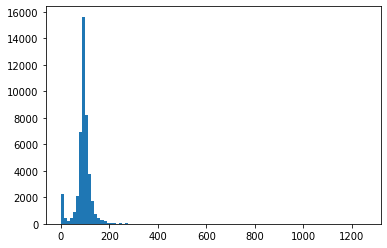

In [118]:
plt.hist(metadata_df.runtime,100)
plt.show()


285


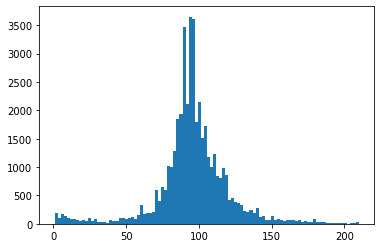

In [119]:
print(len(metadata_df[metadata_df.runtime>210].runtime))
metadata_df = metadata_df[metadata_df.runtime<=210]
runtime_mean = metadata_df[metadata_df.runtime>0].runtime.mean()
metadata_df.runtime = metadata_df.runtime.fillna(runtime_mean)
metadata_df.runtime = metadata_df.runtime.replace(0,runtime_mean)
plt.hist(metadata_df.runtime,100)
plt.show()

We see that 62 datapoints have null values in the release date column. As this is just a small number of datapoints and the release date couldn't be retrieved in any way other than through manual checking, we are going to drop this rows.

In [120]:
mask = metadata_df.release_date.isna()
metadata_df = metadata_df[~mask]

To better analyse the information given by the release date of a film, we extract from the data in the column (which is in the form yyyy-mm-dd), the release year and the day of the year going from 1 to 365.

In [121]:
def convert_date(date): #function to convert a list [month,day], into the numbered day of the year
    year = int(date[0:4])
    day = [int(date[5:7]),int(date[8:10])]
    month_days=[0,31,59,90,120,151,181,212,243,273,304,334]
    return [year,day[1]+month_days[day[0]-1]]

In [122]:
metadata_df['year'] = metadata_df.release_date
metadata_df['day'] = metadata_df.release_date

metadata_df['year'] = metadata_df['year'].apply(lambda x:convert_date(x)[0])
metadata_df['day'] = metadata_df['day'].apply(lambda x:convert_date(x)[1])

metadata_df = metadata_df.drop(['release_date'], axis=1)

The first Academy Award Ceremony was celebrated in 1929, so we can drop any film released before 1928. The metadata dataset was created in 2017, so we are going to drop from both datasets the movies published after that year.

In [124]:
metadata_df = metadata_df[metadata_df.year >= 1928]
metadata_df = metadata_df[metadata_df.year <= 2017]
oscar_df = oscar_df[oscar_df.year_film <= 2017]

As to the budget and revenue columns, we can see only a small portion of the films in the dataset have non-zero values. The information provided by these features could be useful to highlight a difference between movies that have been nominated and films that haven't: for this analysis we will ignore the zero values.
When developing the predictive model we will study if including the budget and revenue columns increases the model's accuracy or not.

In [125]:
metadata_df.budget = metadata_df.budget.apply(lambda x:float(x)) #we transform the type to float

print("Non-zero budget values: ", sum(metadata_df.budget>0))
print("Non-zero revenue values: ", sum(metadata_df.revenue>0))

Non-zero budget values:  8771
Non-zero revenue values:  7357


We now go on to change the format of the columns that are now formatted with JSON (JavaScript Object Notation): genres, production companies, production countries and spoken languages.

In [126]:
n = len(metadata_df.genres)
numero = []
different_genres = []
film_genre = [[] for i in range(n)]

for i in range(n):
    list_dict = js.loads(metadata_df.genres.iloc[i].replace("'",'"')) # the difference between ' and " generated errors
    numero.append(len(list_dict))
    for dict in list_dict:
        film_genre[i].append(dict['name'])
        if dict['name'] not in different_genres: 
            different_genres.append(dict['name'])
    
metadata_df['genres'] = film_genre

print(max(numero))
print(len(different_genres))
print(different_genres)

8
20
['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie']


We find that the maximum number of genres for a single film in this dataset is 8 and that are a total of 20 possible different genres. We have also replaced the genres column with lists of genres instead of JSON dictionaries.
To mantain this information and to be able to analyse it better we create 20 new columns of boolean values, one for each possible genre.
After this we can also drop the previous genre column.

In [127]:
for genre in different_genres:
    metadata_df['genre ' + genre] = False
    for i in range(n):
        if genre in metadata_df.genres.iloc[i]:
            metadata_df['genre ' + genre].iloc[i] = True

metadata_df = metadata_df.drop('genres', axis=1)

C:\Users\dalma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [128]:
n = len(metadata_df.production_companies)
numero = []
different_productions = []
count = []
film_production_company = [[] for i in range(n)]

for i in range(n):
    try:
        list_dict = js.loads(metadata_df.production_companies.iloc[i].replace("'",'"'))
        numero.append(len(list_dict))
        for dict in list_dict:
            film_production_company[i].append(dict['name'])
            count.append(dict['name'])
            if dict['name'] not in different_productions: 
                different_productions.append(dict['name'])
    except: pass #some datapoints have problematic encodings for the production companies that raise errors


metadata_df['production_companies'] = film_production_company
count = pd.Series(count)
print(count.value_counts())
print(max(numero))
print(len(different_productions))
sum(count.value_counts()>500)

Warner Bros.                              1230
Metro-Goldwyn-Mayer (MGM)                 1014
Paramount Pictures                         978
Twentieth Century Fox Film Corporation     818
Universal Pictures                         816
                                          ... 
Minos Films                                  1
Panda Productions Inc.                       1
Horticus UK                                  1
Sanctum Australia                            1
Pirie Productions                            1
Length: 22581, dtype: int64
26
22581


5

We have found that in the dataset are presented more than 22 thousand different production companies and as many as 26 for a single film!
However, only 5 have produced more than 500 films each: to retain some information from this column we are going to create 5 boolean columns, one for each of the largest producing companies and then remove the old producing companies column.

In [129]:
metadata_df['prod_warner'] = False
metadata_df['prod_mgm'] = False
metadata_df['prod_paramount'] = False
metadata_df['prod_20centuryfox'] = False
metadata_df['prod_universal'] = False

for i in range(n):
    if "Warner Bros." in metadata_df.production_companies.iloc[i]: metadata_df.prod_warner.iloc[i] = True
    if "Metro-Goldwyn-Mayer (MGM)" in metadata_df.production_companies.iloc[i]: metadata_df.prod_mgm.iloc[i] = True
    if "Paramount Pictures" in metadata_df.production_companies.iloc[i]: metadata_df.prod_paramount.iloc[i] = True
    if "Twentieth Century Fox Film Corporation" in metadata_df.production_companies.iloc[i]: metadata_df.prod_20centuryfox.iloc[i] = True
    if "Universal Pictures" in metadata_df.production_companies.iloc[i]: metadata_df.prod_universal.iloc[i] = True


metadata_df = metadata_df.drop('production_companies', axis=1)

In [130]:
n = len(metadata_df.production_countries)
numero = []
different_countries = []
count = []
film_production_country = [[] for i in range(n)]

for i in range(n):
    try:
        list_dict = js.loads(metadata_df.production_countries.iloc[i].replace("'",'"')) # the difference between ' and " generated errors
        numero.append(len(list_dict))
        for dict in list_dict:
            film_production_country[i].append(dict['name'])
            count.append(dict['name'])
            if dict['name'] not in different_countries: 
                different_countries.append(dict['name'])
    except: pass

metadata_df['production_countries'] = film_production_country
count = pd.Series(count)
print(count.value_counts())
print(max(numero))
print(len(different_countries))
sum(count.value_counts()>1000)

United States of America                20562
United Kingdom                           4009
France                                   3761
Germany                                  2128
Italy                                    2096
                                        ...  
Kuwait                                      1
Martinique                                  1
United States Minor Outlying Islands        1
Cayman Islands                              1
Guinea                                      1
Length: 158, dtype: int64
25
158


7

We can see that 158 different possible producing countries exist in the dataframe and that a single film can have up to 25 different producing countries. But at the same time, some countries produced a very large number of films compared to the rest: as we did before we are going to create 7 boolean columns, one for each of the countries that have produced more than 1000 movies in this dataset.

In [131]:
metadata_df['country_us'] = False
metadata_df['country_uk'] = False
metadata_df['country_fr'] = False
metadata_df['country_ge'] = False
metadata_df['country_it'] = False
metadata_df['country_ca'] = False
metadata_df['country_ja'] = False

for i in range(n):
    if "United States of America" in metadata_df.production_countries.iloc[i]: metadata_df.country_us.iloc[i] = True
    if "United Kingdom" in metadata_df.production_countries.iloc[i]: metadata_df.country_uk.iloc[i] = True
    if "France" in metadata_df.production_countries.iloc[i]: metadata_df.country_fr.iloc[i] = True
    if "Germany" in metadata_df.production_countries.iloc[i]: metadata_df.country_ge.iloc[i] = True
    if "Italy" in metadata_df.production_countries.iloc[i]: metadata_df.country_it.iloc[i] = True
    if "Canada" in metadata_df.production_countries.iloc[i]: metadata_df.country_ca.iloc[i] = True
    if "Japan" in metadata_df.production_countries.iloc[i]: metadata_df.country_ja.iloc[i] = True


metadata_df = metadata_df.drop('production_countries', axis=1)

The only column left with Json values is the spoken_languages column: given that some information about the language of the film is already given by the original_language column, we are eventually going to discard this feature. As we can see that the original_language column has some null values, we are going to substitute the first spoken language as the original language to fill the NAs.

In [132]:
for i in metadata_df[metadata_df.original_language.isna()].index:
    metadata_df['original_language'].loc[i] = js.loads(metadata_df.spoken_languages.loc[i].replace("'",'"'))[0]['iso_639_1']

metadata_df = metadata_df.drop('spoken_languages', axis=1)
metadata_df.original_language.value_counts()[0:10]

en    31182
fr     2297
it     1441
ja     1332
de      976
es      952
ru      760
hi      493
ko      441
zh      402
Name: original_language, dtype: int64

We can see that the original_language column has 7 languages with more than 500 films. We are once again going to create 7 columns of boolean values to transform this categorical data into numerical data.

In [133]:
metadata_df['language_en'] = False
metadata_df['language_fr'] = False
metadata_df['language_it'] = False
metadata_df['language_ja'] = False
metadata_df['language_de'] = False
metadata_df['language_es'] = False
metadata_df['language_ru'] = False

for i in range(n):
    if metadata_df.original_language.iloc[i] == 'en': metadata_df.language_en.iloc[i] = True
    if metadata_df.original_language.iloc[i] == 'fr': metadata_df.language_fr.iloc[i] = True
    if metadata_df.original_language.iloc[i] == 'it': metadata_df.language_it.iloc[i] = True
    if metadata_df.original_language.iloc[i] == 'ja': metadata_df.language_ja.iloc[i] = True
    if metadata_df.original_language.iloc[i] == 'de': metadata_df.language_de.iloc[i] = True
    if metadata_df.original_language.iloc[i] == 'es': metadata_df.language_es.iloc[i] = True
    if metadata_df.original_language.iloc[i] == 'ru': metadata_df.language_ru.iloc[i] = True


metadata_df = metadata_df.drop('original_language', axis=1)

In [134]:
metadata_df.head()

,adult,budget,original_title,popularity,revenue,runtime,title,vote_average,vote_count,year,...,country_it,country_ca,country_ja,language_en,language_fr,language_it,language_ja,language_de,language_es,language_ru
0,False,30000000.0,Toy Story,21.946943,373554033.0,81.0,Toy Story,7.7,5415.0,1995,...,False,False,False,True,False,False,False,False,False,False
1,False,65000000.0,Jumanji,17.015539,262797249.0,104.0,Jumanji,6.9,2413.0,1995,...,False,False,False,True,False,False,False,False,False,False
2,False,0.0,Grumpier Old Men,11.7129,0.0,101.0,Grumpier Old Men,6.5,92.0,1995,...,False,False,False,True,False,False,False,False,False,False
3,False,16000000.0,Waiting to Exhale,3.859495,81452156.0,127.0,Waiting to Exhale,6.1,34.0,1995,...,False,False,False,True,False,False,False,False,False,False
4,False,0.0,Father of the Bride Part II,8.387519,76578911.0,106.0,Father of the Bride Part II,5.7,173.0,1995,...,False,False,False,True,False,False,False,False,False,False


We have explored and cleaned the data from the two datasets, now we want to join them. We are going to join them on the film title and the release year. Before doing this we want to normalize the film titles to avoid problem related to special characters, ecc.

In [194]:
def normalize(title):
    special_char = [':', '!', '?', ' -', '- ', '-', '/', '.', '·', ',', '"', '...', "'", ' ', '\u200e']
    norm_title = title.lower()
    for c in special_char:
        norm_title = norm_title.replace(c,'')
    
    norm_title = norm_title.replace('ž','z')
    norm_title = norm_title.replace('ń','n')
    norm_title = norm_title.replace('&','and')
    return norm_title.strip()

In [138]:

df = pd.merge(metadata_df, oscar_df,  how='left', left_on=['year','title'], right_on = ['year_film','film'])

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43701 entries, 0 to 43700
Data columns (total 54 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  43701 non-null  object 
 1   budget                 43701 non-null  float64
 2   original_title         43701 non-null  object 
 3   popularity             43701 non-null  object 
 4   revenue                43701 non-null  float64
 5   runtime                43701 non-null  float64
 6   title                  43701 non-null  object 
 7   vote_average           43701 non-null  float64
 8   vote_count             43701 non-null  float64
 9   year                   43701 non-null  int64  
 10  day                    43701 non-null  int64  
 11  genre Animation        43701 non-null  bool   
 12  genre Comedy           43701 non-null  bool   
 13  genre Family           43701 non-null  bool   
 14  genre Adventure        43701 non-null  bool   
 15  ge

In [137]:
oscar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3147 entries, 0 to 4832
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   year_film    3147 non-null   int64 
 1   winner       3147 non-null   int64 
 2   nominations  3147 non-null   int64 
 3   film         3147 non-null   object
dtypes: int64(3), object(1)
memory usage: 122.9+ KB
